In [1]:
from google.colab import drive
# Google Drive 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
!pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 29.1 MB/s eta 0:00:00


In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from dtaidistance import dtw

In [38]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from imblearn.metrics import specificity_score # specificity_score 임포트
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten
import seaborn as sns

In [4]:
df_X_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/X_train_sample100.csv')
df_y_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/y_train_sample100.csv')
df_X_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/X_test_sample100.csv')
df_y_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/y_test_sample100.csv')

In [5]:
X_train = df_X_train.values
y_train = df_y_train.values.reshape(-1)  # 1차원 배열(벡터)로 변환
X_test = df_X_test.values
y_test = df_y_test.values.reshape(-1)  # 1차원 배열(벡터)로 변환

In [6]:
# 소수 클래스와 다수 클래스 식별
target_counts = pd.Series(y_train).value_counts()
minority_class = target_counts.idxmin()
majority_class = target_counts.idxmax()

# 소수 클래스 샘플 추출
X_minority = X_train[y_train == minority_class]
X_major = X_train[y_train == majority_class]

In [11]:
print('major class :', len(X_major), 'minor class :', len(X_minority))

major class : 1172 minor class : 62


In [28]:
len(X_train)

1234

In [14]:
# 소수 클래스와 다수 클래스를 각각 정규화
scaler_minority = MinMaxScaler()
scaler_majority = MinMaxScaler()

X_minority_norm = scaler_minority.fit_transform(X_minority)
X_majority_norm = scaler_majority.fit_transform(X_major)

In [17]:
# Xcenter 정의 (소수 클래스 평균)
Xcenter = np.mean(X_minority_norm, axis=0)

In [22]:
wpd_distances = []
for sample in X_minority_norm:
    distance = dtw.distance(Xcenter, sample)
    wpd_distances.append(distance)

wpd_distances = np.array(wpd_distances)
wpd_mean = np.mean(wpd_distances)
print(f"WPD 평균값: {wpd_mean}")


WPD 평균값: 1.0769579684980064


In [23]:
safe_samples = X_minority_norm[wpd_distances <= wpd_mean]
noisy_samples = X_minority_norm[wpd_distances > wpd_mean]

print(f"안전 샘플 수: {len(safe_samples)}, 노이즈 샘플 수: {len(noisy_samples)}")


안전 샘플 수: 41, 노이즈 샘플 수: 21


In [30]:
# 필요한 수
n_generate = (len(X_train))*2 - (len(X_major)+len(X_minority))
samples_per_safe_point = n_generate // len(safe_samples)  # = 30
remainder = n_generate % len(safe_samples)  # = 4

augmented_samples = []

# 중심점
Xcenter = np.mean(safe_samples, axis=0)

# 1차 증강
for sample in safe_samples:
    for _ in range(samples_per_safe_point):
        alpha = np.random.rand()
        new_sample = alpha * sample + (1 - alpha) * Xcenter
        augmented_samples.append(new_sample)

# 나머지 4개 생성
for i in range(remainder):
    sample = safe_samples[i % len(safe_samples)]
    alpha = np.random.rand()
    new_sample = alpha * sample + (1 - alpha) * Xcenter
    augmented_samples.append(new_sample)

augmented_samples = np.array(augmented_samples)


In [42]:
# 증강된 샘플과 원본 데이터를 합치기
X_minority_final = np.vstack([X_minority, augmented_samples])
y_minority_final = np.array([minority_class] * X_minority_final.shape[0])

X_majority_final = X_majority_norm  # 이미 정규화된 다수 클래스

y_majority_final = np.array([majority_class] * X_majority_final.shape[0])

# 전체 데이터셋 통합
X_synthetic = np.vstack([X_minority_final, X_majority_final])
y_synthetic = np.concatenate([y_minority_final, y_majority_final])

# 교차 검증을 위한 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestClassifier(random_state=42)

In [45]:
best_threshold = None
best_specificity = 0
best_model = None

for fold, (train_index, val_index) in enumerate(skf.split(X_synthetic, y_synthetic)):
    print(f"Fold {fold+1}")

    X_train_fold, X_val_fold = X_synthetic[train_index], X_synthetic[val_index]
    y_train_fold, y_val_fold = y_synthetic[train_index], y_synthetic[val_index]

    rf_model.fit(X_train_fold, y_train_fold)
    y_pred_proba = rf_model.predict_proba(X_val_fold)[:, 1]

    thresholds = np.linspace(0, 1, 100)
    for threshold in thresholds:
        y_pred_temp = (y_pred_proba >= threshold).astype(int)
        specificity = specificity_score(y_val_fold, y_pred_temp)
        if specificity > best_specificity:
            best_specificity = specificity
            best_threshold = threshold
            best_model = rf_model
print(f"Best Threshold: {best_threshold}")
# 최적 모델로 테스트 예측
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= best_threshold).astype(int)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Best Threshold: 0.686868686868687


In [46]:
# 예측 함수들 정의
def predict_with_best_rf(X_test):
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    return (y_pred_proba >= best_threshold).astype(int)

def predict_with_logistic_regression(X_train, y_train, X_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_cart(X_train, y_train, X_test):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_knn(X_train, y_train, X_test, k=3):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_xgboost(X_train, y_train, X_test):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_lstm(X_train, y_train, X_test):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
    return (model.predict(X_test_reshaped) > 0.5).astype(int)

def predict_with_cnn(X_train, y_train, X_test):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
    return (model.predict(X_test_reshaped) > 0.5).astype(int)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:46:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Logistic Regression 모델 성능:
정확도: 0.6131, F1: 0.7601, Recall: 1.0000, Specificity: 0.0000
Confusion Matrix:
[[  0 332]
 [  0 526]]


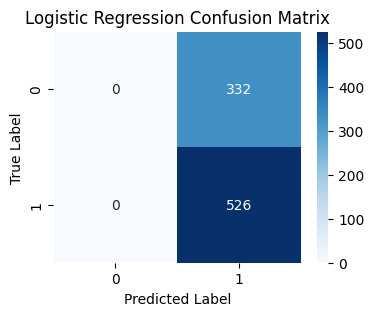

CART 모델 성능:
정확도: 0.3834, F1: 0.0000, Recall: 0.0000, Specificity: 0.9910
Confusion Matrix:
[[329   3]
 [526   0]]


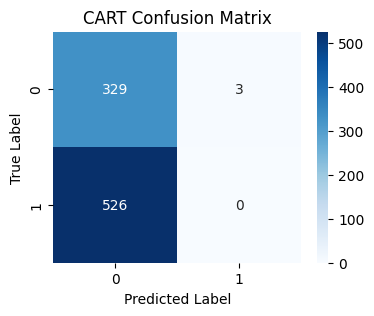

KNN 모델 성능:
정확도: 0.4033, F1: 0.0725, Recall: 0.0380, Specificity: 0.9819
Confusion Matrix:
[[326   6]
 [506  20]]


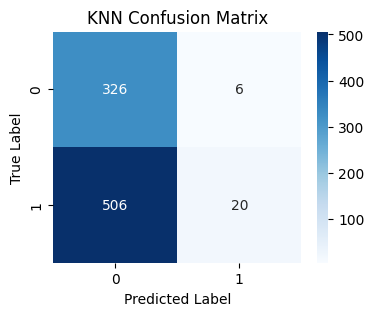

XGBoost 모델 성능:
정확도: 0.5361, F1: 0.5636, Recall: 0.4886, Specificity: 0.6114
Confusion Matrix:
[[203 129]
 [269 257]]


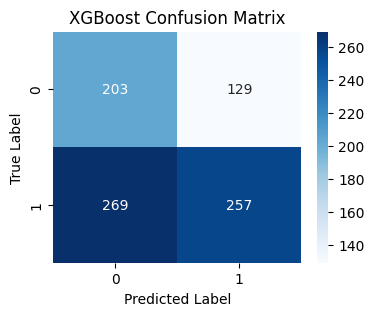

LSTM 모델 성능:
정확도: 0.5198, F1: 0.5391, Recall: 0.4582, Specificity: 0.6175
Confusion Matrix:
[[205 127]
 [285 241]]


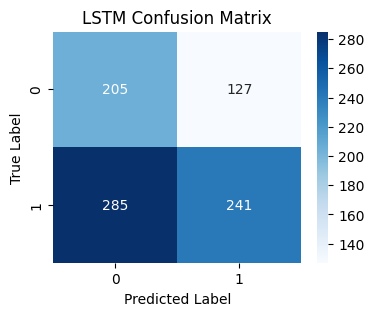

CNN 모델 성능:
정확도: 0.6061, F1: 0.7287, Recall: 0.8631, Specificity: 0.1988
Confusion Matrix:
[[ 66 266]
 [ 72 454]]


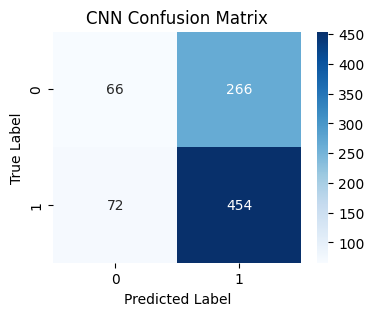

Best Random Forest 모델 성능:
정확도: 0.3869, F1: 0.0000, Recall: 0.0000, Specificity: 1.0000
Confusion Matrix:
[[332   0]
 [526   0]]


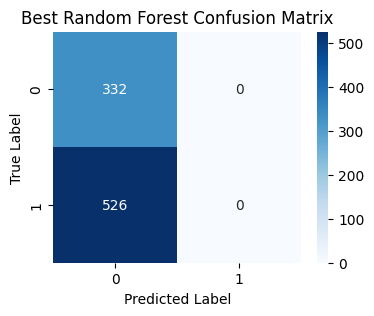

In [47]:
# 예측 실행 및 평가
predictions = {
    "Logistic Regression": predict_with_logistic_regression(X_synthetic, y_synthetic, X_test),
    "CART": predict_with_cart(X_synthetic, y_synthetic, X_test),
    "KNN": predict_with_knn(X_synthetic, y_synthetic, X_test),
    "XGBoost": predict_with_xgboost(X_synthetic, y_synthetic, X_test),
    "LSTM": predict_with_lstm(X_synthetic, y_synthetic, X_test),
    "CNN": predict_with_cnn(X_synthetic, y_synthetic, X_test),
    "Best Random Forest": predict_with_best_rf(X_test)
}

for model_name, pred_y in predictions.items():
    accuracy = accuracy_score(y_test, pred_y)
    recall = recall_score(y_test, pred_y)
    f1 = f1_score(y_test, pred_y)
    specificity = specificity_score(y_test, pred_y)
    conf_matrix = confusion_matrix(y_test, pred_y)

    print(f"{model_name} 모델 성능:")
    print(f"정확도: {accuracy:.4f}, F1: {f1:.4f}, Recall: {recall:.4f}, Specificity: {specificity:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
